In [1]:
import Pkg; Pkg.activate("../"); # Activate the project 

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [2]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Plots", "LaTeXStrings", "Statistics"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

In [3]:
H_parametrized = (delta::Float64, gamma::Float64) -> (0.5*delta*QuTaM.sigma_z)::Matrix{ComplexF64}
L_parametrized = (delta::Float64, gamma::Float64) -> (sqrt(gamma)*QuTaM.sigma_m)::Matrix{ComplexF64}
# Function that constructs returns a parametrization of the effective hamiltonian from 
# the parametrization of the hamiltonian and the jump operators
function GetHeffParametrized(H_par::Function, Ls_par)::Function
    return (input...) -> begin
        LLs_par = [ adjoint(L_par(input...))*L_par(input...) for L_par in Ls_par]
        return H_par(input...) - 0.5im*sum(LLs_par)  
    end 
end 

GetHeffParametrized (generic function with 1 method)

In [4]:
function DerivativeExpHeff(Heff_par::Function, tau::Float64, theta::Vector{Float64}, dtheta::Vector{Float64})
    f1 =  exp(-1im*tau*Heff_par((theta + 2*dtheta)...))
    f2 =  exp(-1im*tau*Heff_par((theta + 1*dtheta)...))
    f3 =  exp(-1im*tau*Heff_par((theta - 1*dtheta)...))
    f4 =  exp(-1im*tau*Heff_par((theta - 2*dtheta)...))
    return (-f1 + 8*f2 - 8*f3 + f4 )/(12*norm(dtheta))
end 

function DerivativesAtJumps(sys::System, Heff_par::Function, Ls_par, traj::Trajectory, psi0::Vector{ComplexF64}, theta::Vector{Float64},
                            dtheta::Vector{Float64})
    # 0. Special Case: if the trajectory is empty, return an empty array
    if isempty(traj)
        return Array{ComplexF64}(undef, 0, 0) 
    end
    # 1. Get the derivatives of L
    nchannels = size(Ls_par)[1]
    dLs = zeros(ComplexF64, sys.NLEVELS, sys.NLEVELS, nchannels)
    
    for k in 1:nchannels
        f1 = Ls_par[k]((theta + 2*dtheta)...) 
        f2 = Ls_par[k]((theta+dtheta)...) 
        f3 = Ls_par[k]((theta-dtheta)...)
        f4 = Ls_par[k]((theta-2*dtheta)...)
        dLs[:, :, k] = (-f1 + 8*f2 - 8*f3 + f4 )/(12*norm(dtheta))
    end 
    # 2.1 Setup 
    njumps = size(traj)[1]
    dpsis = zeros(ComplexF64, sys.NLEVELS, njumps)
    # 2.2 Set up the first jump
    click = traj[1] 
    label = click.label
    tau = click.time
    dpsis[:, 1] .= dLs[:, :, label] * exp(-1im*tau*sys.Heff) * psi0 +
                      sys.Ls[label] * DerivativeExpHeff(Heff_par, tau, theta, dtheta) * psi0 # Derivative
    # In case there are no more jumps, return
    if njumps  == 1 
        return dpsis
    end  
    # 3. Go over the rest of the jumps 
    psitildes = states_at_jumps(traj, sys, psi0; normalize=false)
    for k in 2:njumps 
      click = traj[k] 
      label = click.label
      tau = click.time
      # Calculate the derivative
      dpsis[:, k] .= (dLs[:, :, label]) * exp(-1im*tau*sys.Heff) * psitildes[:, k-1] +
                     sys.Ls[label] * DerivativeExpHeff(Heff_par, tau, theta, dtheta) * psitildes[:, k-1] # Derivative
                     sys.Ls[label] * exp(-1im*tau*sys.Heff) * dpsis[:, k -1]
   end 
   return dpsis 
    
end 



DerivativesAtJumps (generic function with 1 method)

In [5]:
Heff_parametrized = GetHeffParametrized(H_parametrized, [L_parametrized])
sys = QuTaM.rd_sys 
traj = [DetectionClick(0.1, 1)]
psi0 = [0.0 + 0im, 1.0+ 0im]
DerivativesAtJumps(sys, Heff_parametrized, [L_parametrized], traj, psi0, 
                    [QuTaM.rd_deltaomega, QuTaM.rd_gamma], [0.0, QuTaM.rd_gamma/100])

2×1 Matrix{ComplexF64}:
 0.17355820485444767 - 0.01129719801926627im
                 0.0 + 0.0im

In [6]:
0.5/sqrt(QuTaM.rd_gamma) * exp(-1im*traj[1].time*(0.5*QuTaM.rd_deltaomega - 0.5im*QuTaM.rd_gamma)) +
sqrt(QuTaM.rd_gamma)*(-0.5*traj[1].time)*exp(-1im*traj[1].time*(0.5*QuTaM.rd_deltaomega - 0.5im*QuTaM.rd_gamma))

0.17355820539697653 - 0.011297198054579793im

In [7]:
function MonitoringOperator(t_given::Vector{Float64}, 
    sys::System, Heff_par::Function, Ls_par, traj::Trajectory, psi0::Vector{ComplexF64}, theta::Vector{Float64},
                            dtheta::Vector{Float64})
 
    # Special case: if the time array is empty, return an empty array
    if isempty(t_given)
        return Array{ComplexF64}(undef, 0, 0, 0)
    end
    psi = evaluate_at_t(t_given, traj, sys, psi0; normalize=false)
    ntimes = size(t_given)[1]
    njumps = size(traj)[1]
    t_ = 0
    counter = 1
    counter_c = 1
    xis = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes)
    # Edge case
    if isempty(traj)
        while counter <= ntimes
            tmp = DerivativeExpHeff(Heff_par, t_given[counter], theta, dtheta) * psi0
            xis[:, :, counter] = (adjoint(tmp) .* psi[:, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:,counter])
            counter = counter + 1
            if counter > ntimes
                break
            end
        end
        return states
    end
    # Evaluations before first jump
    while (t_given[counter] < traj[counter_c].time) && (counter <= ntimes)
            tmp = DerivativeExpHeff(Heff_par, t_given[counter], theta, dtheta) * psi0
            xis[:, :, counter] = (adjoint(tmp) .* psi[:, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:, counter])
            counter = counter + 1
            if counter > ntimes
                break
            end
    end
    dpsijumps = DerivativesAtJumps(sys, Heff_par, Ls_par, traj, psi0, theta, dtheta)
    psijumps = states_at_jumps(traj, sys, psi0; normalize=false)
    t_ = t_ + traj[counter_c].time
    counter_c = counter_c + 1
    # Evaluation after first jump
    while (counter_c <= njumps) && (counter <= ntimes)
        timeclick = traj[counter_c].time
        while (t_ < t_given[counter] < t_ + timeclick) && (counter <= ntimes)
            tmp = (DerivativeExpHeff(Heff_par, t_given[counter]-t_, theta, dtheta) * psijumps[:, counter_c-1]+
                   exp(-1im*(t_given[counter]-t_)*sys.Heff)*dpsijumps[:, counter_c-1] ) 
            xis[ :, :,counter] = (adjoint(tmp) .* psi[ :, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:, counter])
            counter = counter + 1
            if counter > ntimes
                break
            end
         end
       t_ = t_ + timeclick
       counter_c = counter_c + 1
    end

    while counter <= ntimes
        tmp = (DerivativeExpHeff(Heff_par, t_given[counter]-t_, theta, dtheta) * psijumps[:, njumps]+
                   exp(-1im*(t_given[counter]-t_)*sys.Heff)*dpsijumps[:, njumps] )
        xis[ :, :,counter] = (adjoint(tmp) .* psi[ :, counter] +  adjoint(psi[:, counter]) .* tmp)/dot(psi[:, counter], psi[:, counter])
        counter = counter + 1
    end
    return xis
end




MonitoringOperator (generic function with 1 method)

In [17]:
sys = QuTaM.rd_sys 

params = SimulParameters(QuTaM.rd_psi0,
    3.0, # Final time. Set very long so that all trajectories jump
    1, # seed
    2500, # Number of trajectories
    50_000, # Number of samples in the finegrid
    10.5, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)


SimulParameters(psi0=ComplexF64[0.0 + 0.0im, 1.0 + 0.0im]
nsamples=50000
seed=1
ntraj=2500)
multiplier=10.5
tf=3.0
dt=0.00063
eps=0.001)

In [18]:
trajectories = run_trajectories(sys, params);

Sampling... 100%|████████████████████████████████████████| Time: 0:00:47


In [19]:
ntimes = 1000
t_given = collect(LinRange(0, params.tf, ntimes));

In [20]:
xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
for n in 1:params.ntraj
    xi_sample[:, :, :, n] = MonitoringOperator(t_given, sys, Heff_parametrized, [L_parametrized], trajectories[n], params.psi0,
                           [QuTaM.rd_deltaomega, QuTaM.rd_gamma], [0.0, QuTaM.rd_gamma/100])
end 

In [21]:
fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
for n in 1:params.ntraj
    for k in 1:ntimes
       fi_sample[k, n] = real(tr(xi_sample[:, :, k, n]))^2 
    end 
end 

In [22]:
fi = dropdims(mean(fi_sample, dims=2), dims=2);

In [23]:
f_analytical(t) = (1-exp(-QuTaM.rd_gamma*t))/(QuTaM.rd_gamma^2)

f_analytical (generic function with 1 method)

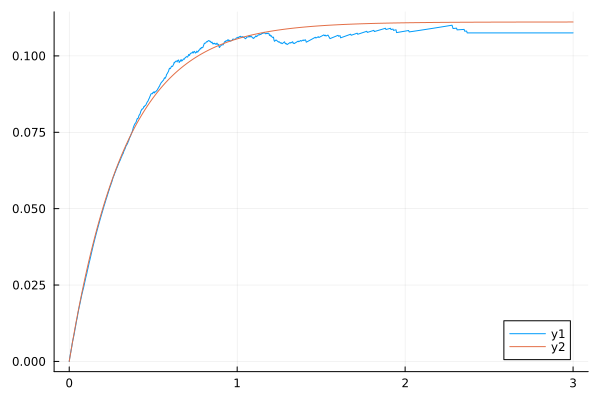

In [24]:
plot(t_given, fi)
plot!(t_given, f_analytical.(t_given))